In [1]:
#suppress warnings
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
#import libraries
import pandas as pd
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
#import Dataset
day = pd.read_csv("C:/Users/dell/Desktop/PLR/day.csv") 
print(day.shape) 
print(day.duplicated().sum()) # Check for any duplicate entries
day.info()

(730, 16)
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


- There is no Null values in the column and majority of data are having numerical values except date column.
- There is no duplicate entries found in the dataset

In [4]:
day.describe() #Statical detail of Dataset

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


### Univariate Analysis

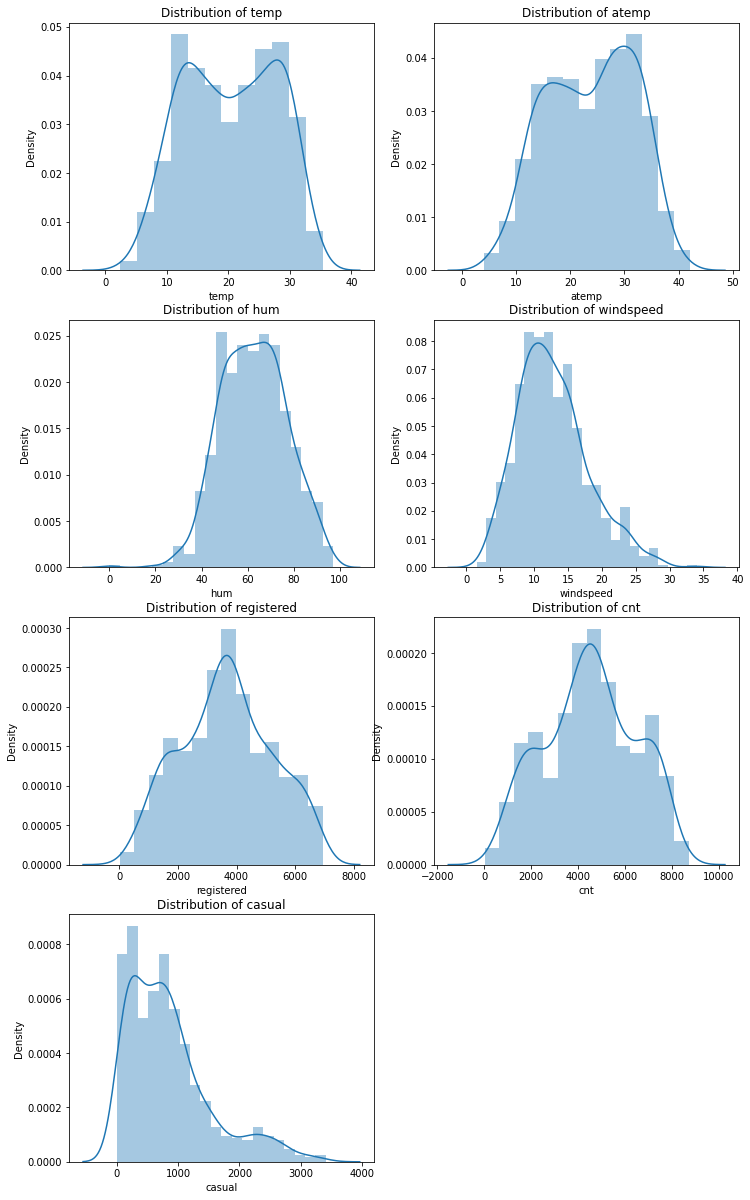

In [5]:
#checking outliers of continous variables by distribution plot
continous_vaiables = ['temp','atemp', 'hum', 'windspeed', 'registered', 'cnt', 'casual']
plt.figure(figsize=(12,18))
for i,v in enumerate(continous_vaiables):
    plt.subplot(4,2,i+1)
    sns.distplot(day[v])
    plt.title('Distribution of ' + v)
    plt.xlabel(v)
    plt.ylabel('Density')
    plt.subplots_adjust(bottom = 0.001)
plt.show()

- Distribution of 'temp' and 'atemp' shows similar distribution. There can be high collinearity between these variables
- Distribution of 'casual' seems right skewed. We need to check if sum of 'casual' and 'registered' is equal to 'cnt'

In [6]:
# validating if sum of 'casual' and 'registered' is equal to 'cnt'
print(day[(day['casual'] + day['registered']) == day['cnt']].shape)
print((day['casual'] + day['registered']).sum())
print((day['cnt']).sum())

(730, 16)
3290845
3290845


- Since the number of rows after filtering has not changed and is 730, we can validate that sum of 'casual' and 'registered' is equal to 'cnt' Even arthmatic sum of 'casual' and 'registered' both columns are equal to 'cnt'.

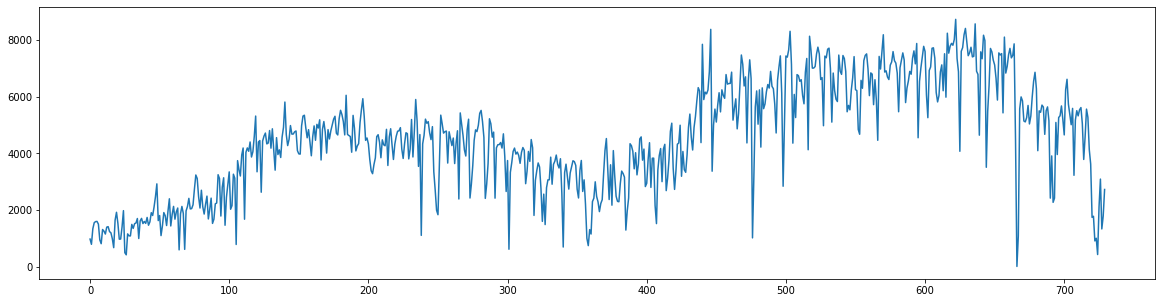

In [7]:
# Checking pattern of target - 'cnt' over period of two years
plt.figure(figsize=(20,5))
plt.plot(day.cnt)
plt.show()

- We can observe that there was growth over the period and recently we could see there is reduction in demand

In [8]:
# identify categorical variables
categorical_vaiables = ['season','yr','mnth','holiday','weekday', 'workingday','weathersit']

# identify numeric variables
num_vars = ['temp', 'hum','windspeed','cnt']

day[categorical_vaiables] = day[categorical_vaiables].astype('category')
day.describe(include=['category'])


,season,yr,mnth,holiday,weekday,workingday,weathersit
count,730,730,730,730,730,730,730
unique,4,2,12,2,7,2,3
top,3,0,1,0,0,1,1
freq,188,365,62,709,105,499,463


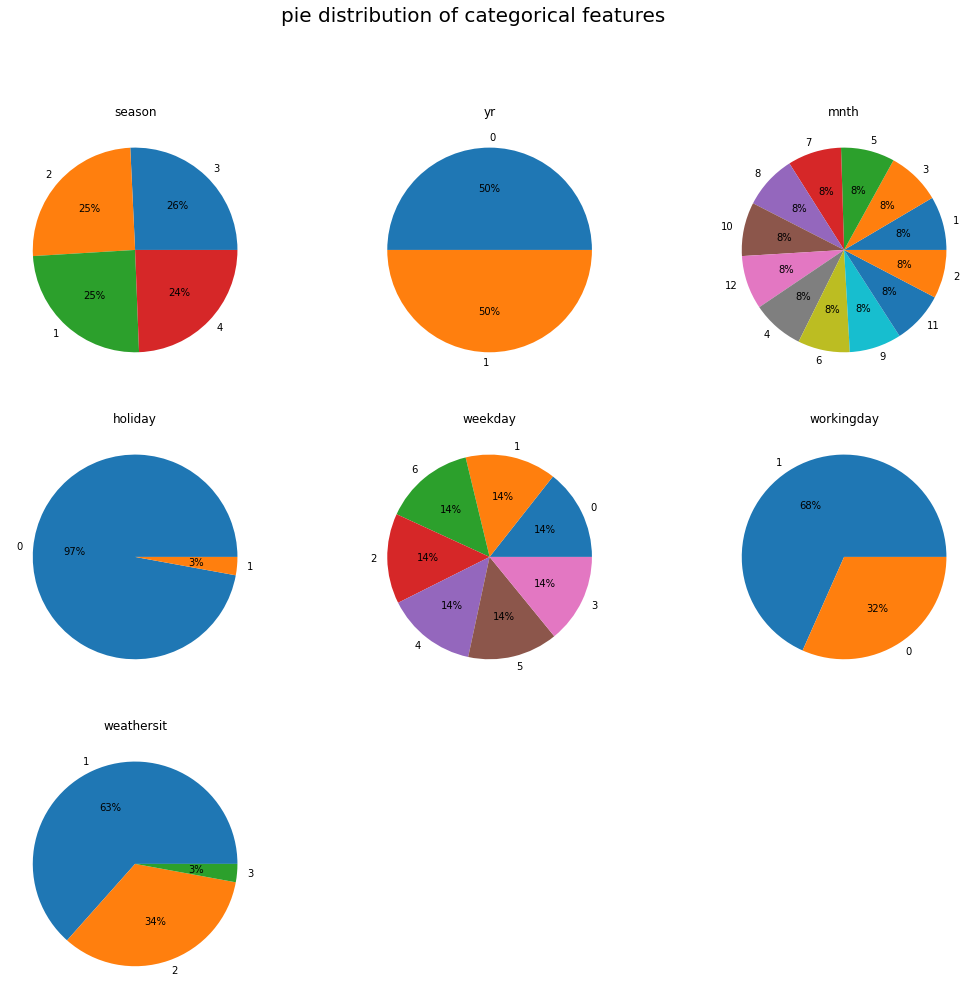

In [9]:
#checking distribution of categorical variable
categorical_vaiables = ['season','yr','mnth','holiday','weekday','workingday', 'weathersit']
day[categorical_vaiables] = day[categorical_vaiables].astype('category')

#Visulalising Categorical Variables using pie chart

day_piplot=day.select_dtypes(include='category')
plt.figure(figsize=(18,16))
plt.suptitle('pie distribution of categorical features', fontsize=20)
for i in range(1,day_piplot.shape[1]+1):
    plt.subplot(3,3,i)
    f=plt.gca()
    f.set_title(day_piplot.columns.values[i-1])
    values=day_piplot.iloc[:,i-1].value_counts(normalize=True).values
    index=day_piplot.iloc[:,i-1].value_counts(normalize=True).index
    plt.pie(values,labels=index,autopct='%1.0f%%')
plt.show()

### Bivariate Analysis¶ 

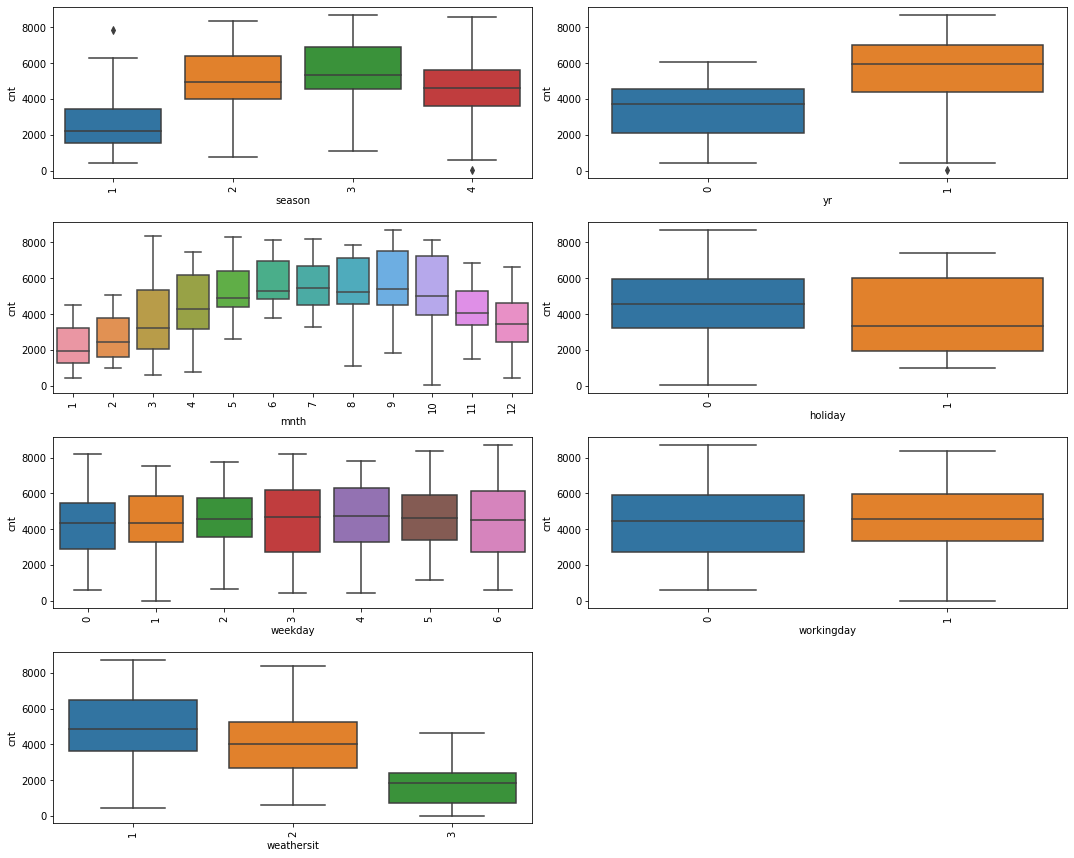

In [10]:
# Box plot for categorical variables
plt.figure(figsize=(15,12))
for i in list(enumerate(categorical_vaiables)):
    plt.subplot(4,2,i[0]+1)
    sns.boxplot(x = i[1], y = 'cnt', data = day)
    plt.xticks(rotation = 90)
plt.tight_layout(pad = 1)    
plt.show()

In [11]:
#type casting
day[['season', 'weathersit']] = day[['season', 'weathersit']].astype(object)
day[['temp', 'atemp', 'hum', 'windspeed']] = day[['temp', 'atemp', 'hum', 'windspeed']].astype(float)
day[['yr', 'mnth', 'holiday', 'weekday','workingday','cnt']] = day[['yr', 'mnth', 'holiday', 'weekday','workingday','cnt']].astype(int)
day.dtypes

instant         int64
dteday         object
season         object
yr              int32
mnth            int32
holiday         int32
weekday         int32
workingday      int32
weathersit     object
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int32
dtype: object

### Data Visualization

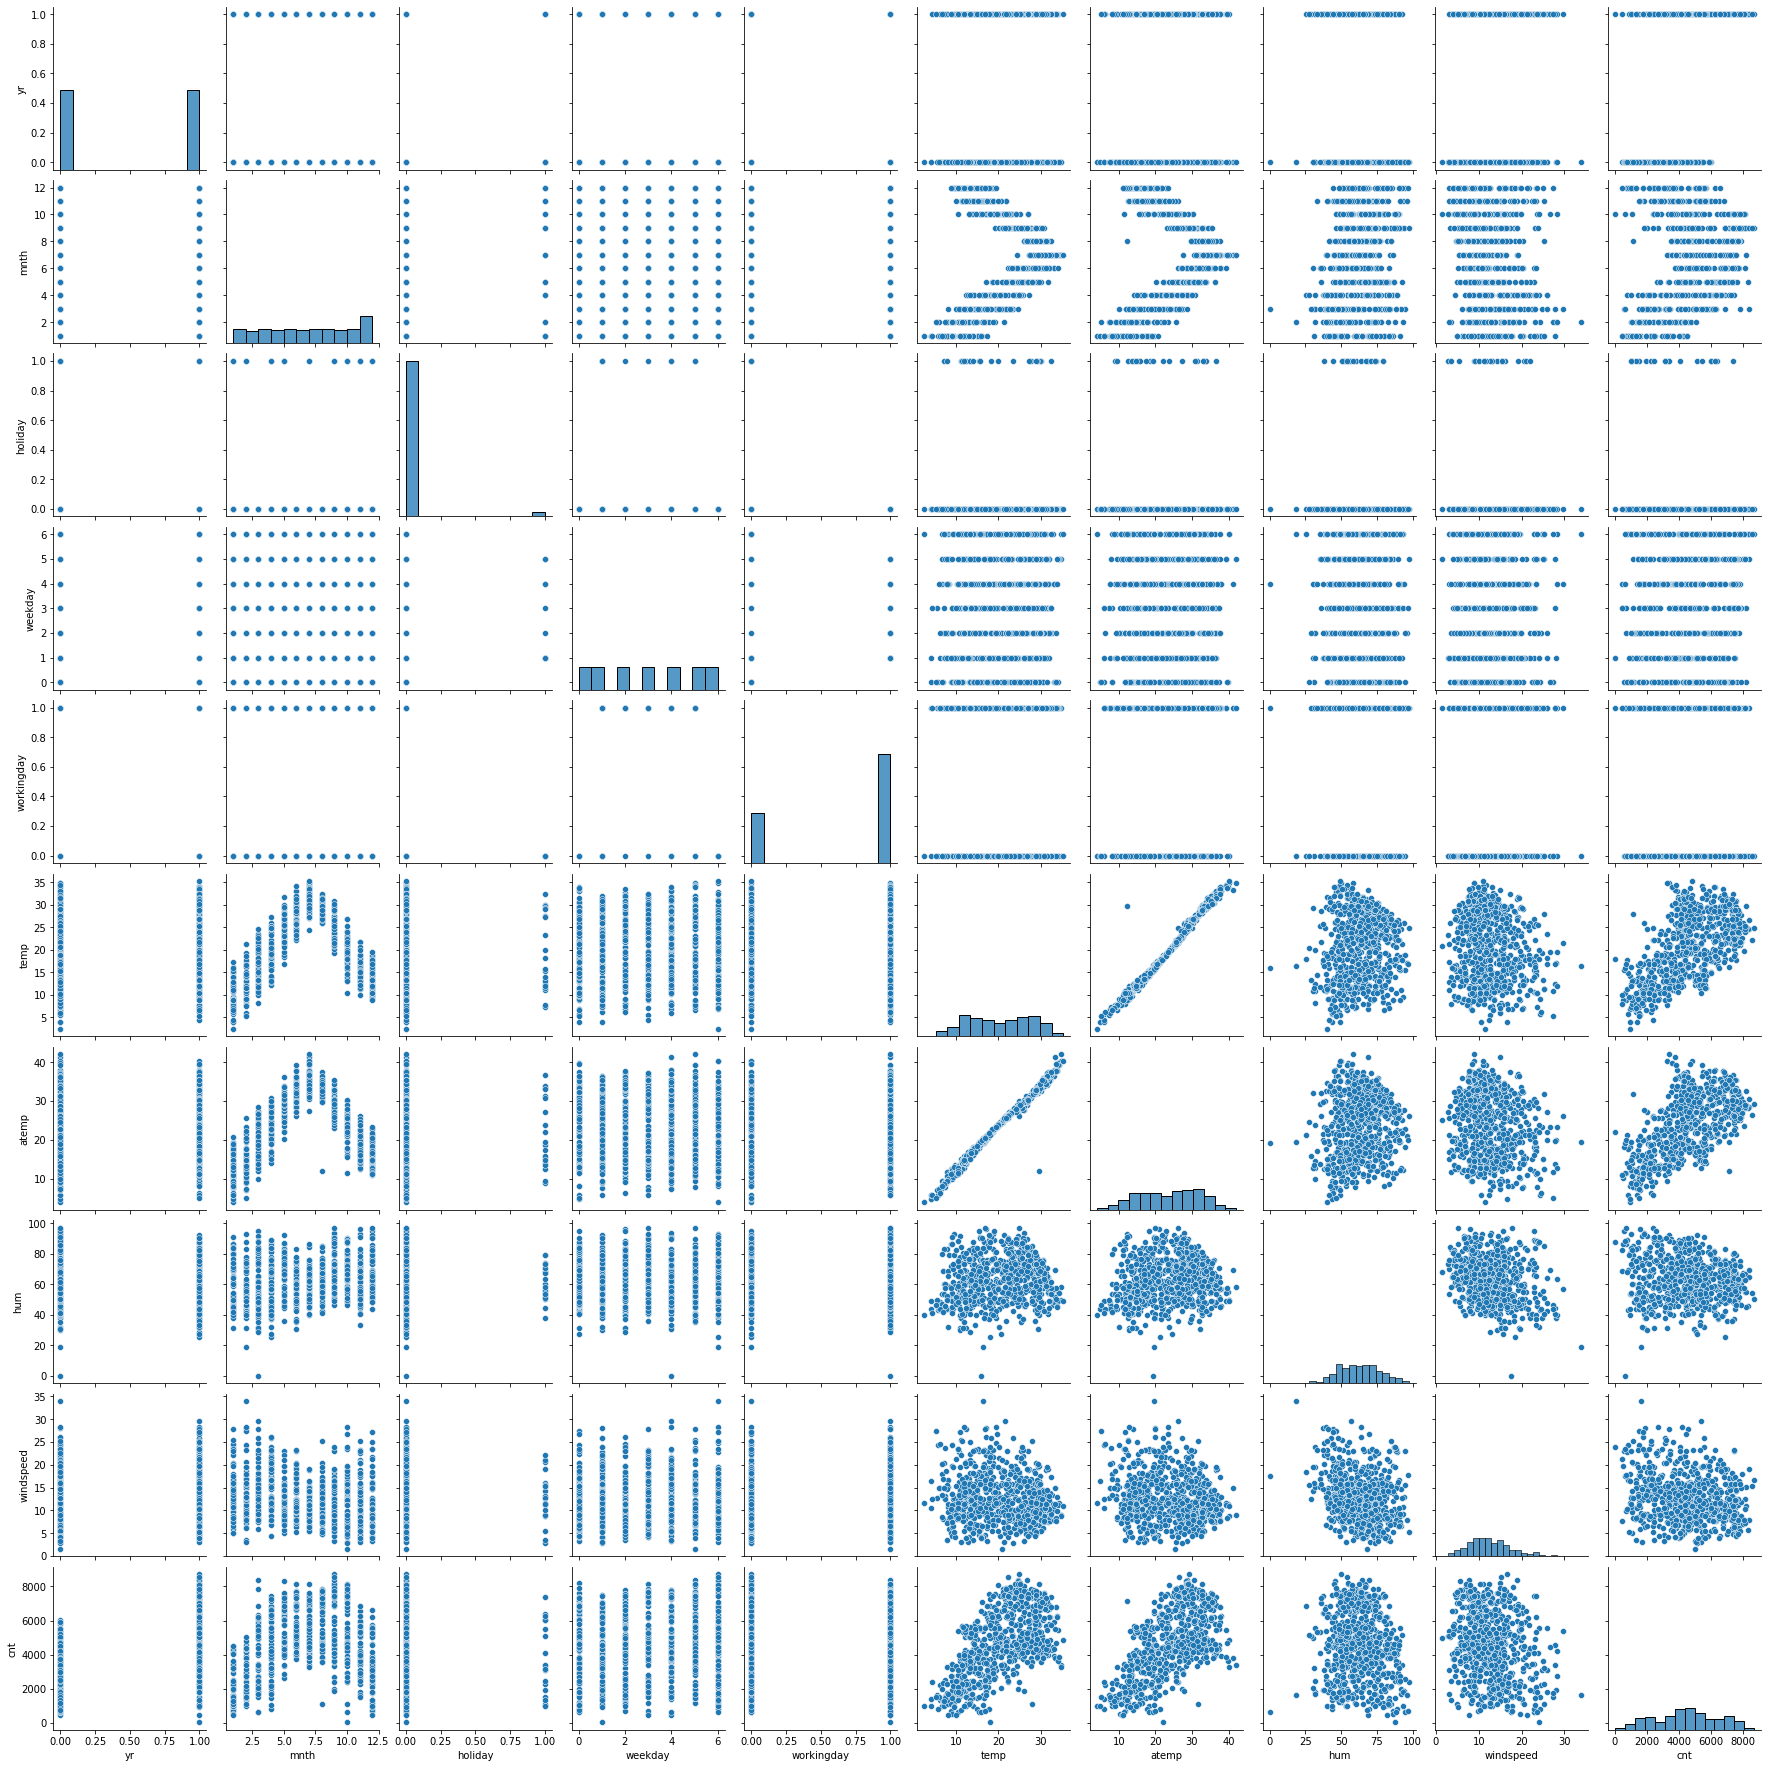

In [12]:
#pairplot for all numerical variables
sns.pairplot(day.select_dtypes(include=['int', 'float']))
plt.show()

#### Inferences made from above plots

- The demand of bike is less in the month of spring when compared with other seasons
- The demand bike increased in the year 2019 when compared with year 2018.
- Month Jun to Sep is the period when bike demand is high. The Month Jan is the lowest demand month.
- Bike demand is less in holidays in comparison to when it is not a holiday.
- The demand of bike is almost similar throughout the weekdays.
- There is no significant change in bike demand with working day and non-working day.
- The bike demand is high when weather is clear and few clouds however demand is less in case of Light snow and light rainfall. We do not have any date for Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog, so we cannot derive any conclusion. May be the company is not operating on those days or there is no demand of bike.
- From the distribution plot of variables in diagonals we can see that there are no outliers. 

#### Removing non-relevat features

- 'instant' : index of data, not needed to build model
- 'casual' and 'registered' : Since target variable 'cnt' is sum of these features, it should be removed.
- 'dteday' : Since all the features from the data is available in other features as weekday, yr and month. So it is not needed.

In [14]:
day.drop(['instant', 'casual', 'registered', 'dteday'], axis=1, inplace=True)
print(day.shape)
day.head()

(730, 12)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


### Data Preparation

In [15]:
day[['season', 'weathersit']] = day[['season', 'weathersit']].astype(object) # converting dtype
dummy_vars = pd.get_dummies(day[['season','weathersit']],drop_first=True)# dummy variable creation
day = pd.concat([day,dummy_vars], axis = 1) #adding to original dataset
day.drop(['season','weathersit'], axis=1, inplace=True)#removing extra columns
day.head()#checking dataset after all this

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,season_4,weathersit_2,weathersit_3
0,0,1,0,6,0,14.110847,18.18125,80.5833,10.749882,985,0,0,0,1,0
1,0,1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,0,1,0
2,0,1,0,1,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,0,0,0
3,0,1,0,2,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,0,0,0
4,0,1,0,3,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,0,0,0


#### Splitting the data into training and test set 

In [16]:
day_train, day_test = train_test_split(day, train_size= 0.7, random_state=30)#creating test and train dataset
print(day_train.shape)
print(day_test.shape)

(510, 15)
(220, 15)


In [17]:
#rescaling numerical variables using MinMaxScaler
scaler = MinMaxScaler()#call scaler
num_vars = ['mnth','weekday','temp', 'atemp', 'hum', 'windspeed', 'cnt']#list of columns to be scaled
day_train[num_vars] = scaler.fit_transform(day_train[num_vars])#column scaling
day_train.head() #checking dataset

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,season_4,weathersit_2,weathersit_3
155,0,0.454545,0,0.000000,0,0.720868,0.690038,0.670951,0.239759,0.561896,1,0,0,1,0
108,0,0.272727,0,0.333333,1,0.534417,0.513618,0.684661,0.279504,0.366084,1,0,0,1,0
493,1,0.363636,0,0.500000,1,0.624917,0.601819,0.765210,0.399983,0.540152,1,0,0,1,0
405,1,0.090909,0,0.833333,1,0.240020,0.242927,0.555270,0.194894,0.438219,0,0,0,1,0
90,0,0.272727,0,0.833333,1,0.265099,0.228951,0.705656,0.487178,0.253682,1,0,0,1,0


In [18]:
day_train.describe()#train data statical details

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,season_4,weathersit_2,weathersit_3
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.496078,0.491266,0.037255,0.503268,0.660784,0.516161,0.490106,0.647173,0.345580,0.509120,0.252941,0.243137,0.239216,0.349020,0.029412
std,0.500476,0.315557,0.189572,0.339321,0.473908,0.240757,0.226141,0.145878,0.157766,0.222752,0.435124,0.429398,0.427024,0.477128,0.169124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.181818,0.000000,0.166667,0.000000,0.307623,0.293997,0.534597,0.232055,0.354119,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.454545,0.000000,0.500000,1.000000,0.498436,0.489165,0.645673,0.321786,0.521859,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.795455,0.000000,0.833333,1.000000,0.726592,0.677806,0.754820,0.435589,0.672141,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Training the data


#### Using sklearn LinearRegression to build a model 

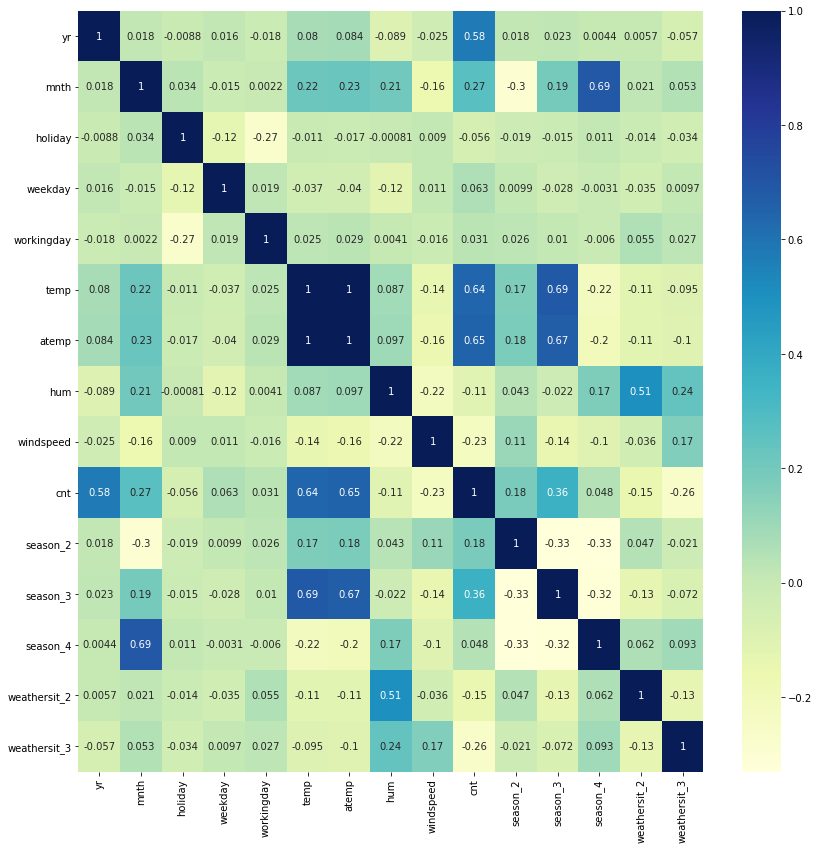

In [19]:
#Checking the correlation between variables
plt.figure(figsize=(14,14))#size discription
sns.heatmap(day_train.corr(), annot=True, cmap='YlGnBu')#plot heatmap
plt.show()#print

In [20]:
#creating predictor and target training variable
y_train = day_train['cnt'] #target of train data
X_train = day_train.drop(['cnt', 'temp'], axis=1)#pridicictor of training data
print(y_train.shape)
print(X_train.shape)

(510,)
(510, 13)


In [21]:
#creating instant of linear regression
lm = LinearRegression()

#training the model without any feature elimination
lm.fit(X_train, y_train)

LinearRegression()

In [22]:
y_train_pred = lm.predict(X_train)#predicition of target variable in train data set
r2_score(y_true= y_train, y_pred=y_train_pred)#checking r2 score

0.8256989390631787

In [23]:
#using RFE(recursive feature elimination) to reduce the dimension of data
rfe = RFE(lm, 11)
rfe = rfe.fit(X_train,y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('mnth', False, 3),
 ('holiday', True, 1),
 ('weekday', True, 1),
 ('workingday', False, 2),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_2', True, 1),
 ('season_3', True, 1),
 ('season_4', True, 1),
 ('weathersit_2', True, 1),
 ('weathersit_3', True, 1)]

In [24]:
#columns to choose for training the data
col_train = X_train.columns[rfe.support_]
col_train

Index(['yr', 'holiday', 'weekday', 'atemp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'weathersit_2', 'weathersit_3'],
      dtype='object')

In [25]:
#columns to be excluded from training data
X_train.columns[~rfe.support_]

Index(['mnth', 'workingday'], dtype='object')

### Building model using statsmodel

In [26]:
#creating training data
X_train_rfe = X_train[col_train]
#adding constant to variable
X_train_sm = sm.add_constant(X_train_rfe)
#creating model using statsmodel
lm = sm.OLS(y_train, X_train_sm) #creating an instant
lm_model = lm.fit() #training the model
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     214.0
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          9.43e-181
Time:                        09:20:36   Log-Likelihood:                 487.76
No. Observations:                 510   AIC:                            -951.5
Df Residuals:                     498   BIC:                            -900.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2334      0.030      7.755      0.000       0.174       0.293
yr               0.2258      0.008     26.691      0.000       0.209       0.242
holiday         -0.0440      0.022     -1.981      0.048      -0.088      -0.000
weekday          0.0393      0.013      3.139      0.002       0.015       0.064
atemp            0.4590      0.034     13.499      0.000       0.392       0.526
hum             -0.1612      0.039     -4.100      0.000      -0.238      -0.084
windspeed       -0.1563      0.029     -5.437      0.000      -0.213      -0.100
season_2         0.1402      0.015      9.071      0.000       0.110       0.171
season_3         0.0971      0.020      4.750      0.000       0.057       0.137
season_4         0.1648      0.013     12.603      0.000       0.139       0.191
weathersit_2    -0.0381      0.011     -3.424      0.001      -0.060      -0.016
weathersit_3    -0.2123      0.028     -7.548      0.000      -0.268      -0.157
==============================================================================
Omnibus:                       66.723   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.771
Skew:                          -0.711   Prob(JB):                     8.17e-33
Kurtosis:                       5.220   Cond. No.                         20.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### The p-value of all variables coeffcients are significant (less than 0.05).

In [27]:
#checking variance inflation factor
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif.transpose()

,0,1,2,3,4,5,6,7,8,9,10
Features,yr,holiday,weekday,atemp,hum,windspeed,season_2,season_3,season_4,weathersit_2,weathersit_3
VIF,1.96,1.06,2.97,18.77,14.57,4.55,3.45,5.82,2.36,2.19,1.2


- VIF of 'hum' and 'atemp' is too high.
- Since the variable 'atemp' has high correlation with target variable, we will first remove 'hum'.

In [28]:
#removing 'hum' variable from dataset
X_train_rfe.drop(['hum'], axis=1, inplace=True)

In [29]:
#creating model after dropping variable

#adding constant to variable
X_train_sm = sm.add_constant(X_train_rfe)

#creating model using statsmodel
lm = sm.OLS(y_train, X_train_sm) #creating an instant
lm_model = lm.fit() #training the model
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     226.6
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          2.30e-178
Time:                        09:20:36   Log-Likelihood:                 479.30
No. Observations:                 510   AIC:                            -936.6
Df Residuals:                     499   BIC:                            -890.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1356      0.019      7.275      0.000       0.099       0.172
yr               0.2303      0.009     27.026      0.000       0.214       0.247
holiday         -0.0453      0.023     -2.010      0.045      -0.090      -0.001
weekday          0.0454      0.013      3.600      0.000       0.021       0.070
atemp            0.4354      0.034     12.791      0.000       0.369       0.502
windspeed       -0.1228      0.028     -4.386      0.000      -0.178      -0.068
season_2         0.1387      0.016      8.842      0.000       0.108       0.170
season_3         0.1008      0.021      4.857      0.000       0.060       0.142
season_4         0.1586      0.013     12.020      0.000       0.133       0.184
weathersit_2    -0.0651      0.009     -7.158      0.000      -0.083      -0.047
weathersit_3    -0.2608      0.026    -10.054      0.000      -0.312      -0.210
==============================================================================
Omnibus:                       62.247   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.351
Skew:                          -0.689   Prob(JB):                     8.16e-29
Kurtosis:                       5.047   Cond. No.                         14.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
#checking variance inflation factor
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif.transpose()

,0,1,2,3,4,5,6,7,8,9
Features,yr,holiday,weekday,atemp,windspeed,season_2,season_3,season_4,weathersit_2,weathersit_3
VIF,1.95,1.05,2.81,13.68,3.97,3.43,5.65,2.28,1.5,1.1


- 'season_3' has high VIF and also is highly correlated with 'atemp'
- 'atemp' has high correlation with target variable.
- So, we will first remove 'season_3' and check.

In [31]:
#removing 'season_3' variable from dataset
X_train_rfe.drop(['season_3'], axis=1, inplace=True)

In [32]:
#creating model after dropping variable 'season_3'

#adding constant to dataset
X_train_sm = sm.add_constant(X_train_rfe)

#creating model using statsmodel
lm = sm.OLS(y_train, X_train_sm) #creating an instant
lm_model = lm.fit() #training the model
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     238.4
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          1.40e-174
Time:                        09:20:36   Log-Likelihood:                 467.52
No. Observations:                 510   AIC:                            -915.0
Df Residuals:                     500   BIC:                            -872.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1192      0.019      6.359      0.000       0.082       0.156
yr               0.2283      0.009     26.237      0.000       0.211       0.245
holiday         -0.0474      0.023     -2.057      0.040      -0.093      -0.002
weekday          0.0459      0.013      3.558      0.000       0.021       0.071
atemp            0.5695      0.020     27.985      0.000       0.530       0.610
windspeed       -0.1257      0.029     -4.392      0.000      -0.182      -0.069
season_2         0.0820      0.011      7.658      0.000       0.061       0.103
season_4         0.1215      0.011     11.046      0.000       0.100       0.143
weathersit_2    -0.0647      0.009     -6.965      0.000      -0.083      -0.046
weathersit_3    -0.2553      0.026     -9.637      0.000      -0.307      -0.203
==============================================================================
Omnibus:                       47.688   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.481
Skew:                          -0.567   Prob(JB):                     1.37e-20
Kurtosis:                       4.738   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
#checking variance inflation factor
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif.transpose()

,0,1,2,3,4,5,6,7,8
Features,yr,holiday,weekday,atemp,windspeed,season_2,season_4,weathersit_2,weathersit_3
VIF,1.94,1.05,2.8,3.68,3.86,1.55,1.4,1.5,1.1


- The p-value of all variables shows that they are significant.
- The VIF of features are now within limit (VIF<4). 

### Residual analysis of training data

In [34]:
#predicting on training data
y_train_pred = lm_model.predict(X_train_sm)

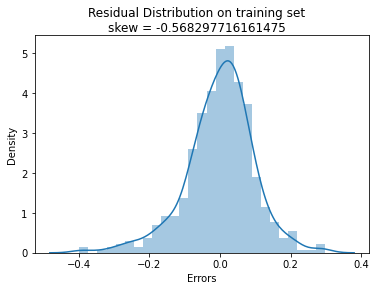

In [35]:
#plotting residual
res = y_train - y_train_pred
skew = res.skew()
std_dev = res.std()
sns.distplot(res)
plt.suptitle('Residual Distribution on training set' + '\nskew = ' + str(skew))
plt.xlabel('Errors')
plt.show()

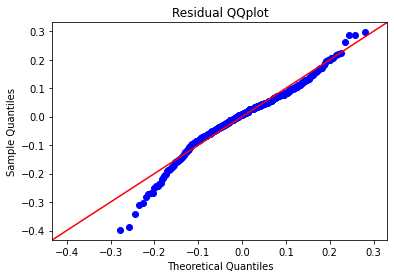

In [36]:
# plotting the Q-Q plot of residual against normal distribution
fig = sm.qqplot(res, line='45', loc=0, scale=std_dev)
plt.title('Residual QQplot')
plt.savefig('Residual_QQplot')
plt.show()

#### From the plot we can visulize that the distribution of residuals is mostly normal.



### Prediction and evaluation on test set

In [37]:
#rescaling the test data
#create a list of features to be scaled
num_vars = ['mnth','weekday','temp', 'atemp', 'hum', 'windspeed', 'cnt']

#scaling the data
day_test[num_vars] = scaler.transform(day_test[num_vars])

day_test.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,season_4,weathersit_2,weathersit_3
293,0,0.818182,0,0.833333,1,0.431924,0.422794,0.590403,0.410258,0.492637,0,0,1,0,0
334,0,1.000000,0,0.666667,1,0.281454,0.259520,0.539417,0.407706,0.426254,0,0,1,0,0
158,0,0.454545,0,0.500000,1,0.887692,0.842846,0.639674,0.235894,0.503797,1,0,0,0,0
677,1,0.909091,0,0.833333,1,0.345786,0.328484,0.556126,0.396161,0.686838,0,0,1,0,0
642,1,0.818182,0,0.833333,1,0.677254,0.639390,0.645244,0.173084,0.935803,0,0,1,0,0


In [38]:
day_test.describe()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,season_4,weathersit_2,weathersit_3
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000,220.000000,220.000000,220.000000,220.000000
mean,0.509091,0.528099,0.009091,0.490909,0.736364,0.532274,0.500508,0.641292,0.348857,0.532307,0.250,0.290909,0.254545,0.309091,0.027273
std,0.501057,0.308378,0.095128,0.323160,0.441609,0.236927,0.224246,0.147862,0.164998,0.222356,0.434,0.455217,0.436599,0.463173,0.163248
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.050062,-0.053751,0.261354,0.050010,0.078578,0.000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.272727,0.000000,0.166667,0.000000,0.332227,0.319763,0.534704,0.228196,0.373073,0.000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.545455,0.000000,0.500000,1.000000,0.566037,0.552480,0.641602,0.334191,0.515014,0.000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.818182,0.000000,0.833333,1.000000,0.732862,0.681523,0.742395,0.433669,0.711804,0.250,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.948753,0.930149,0.997858,0.810267,0.963300,1.000,1.000000,1.000000,1.000000,1.000000


In [39]:
#creating predictor and target variable from test set
y_test = day_test['cnt']
X_test = day_test[X_train_rfe.columns]

#adding constant to dataset
X_test_sm = sm.add_constant(X_test)

#predicting on test data
y_test_pred = lm_model.predict(X_test_sm)

### Model Evaluation 

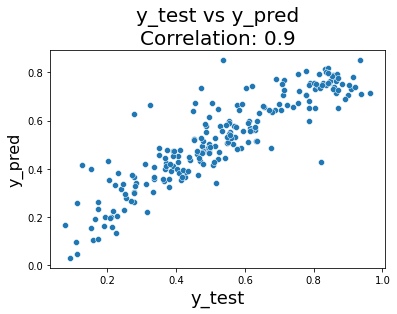

In [40]:
#plotting y_test and y_test_pred
corr = round(np.corrcoef(y_test, y_test_pred)[0][1],2)
sns.scatterplot(x = y_test, y = y_test_pred)
plt.title('y_test vs y_pred' + '\nCorrelation: ' + str(corr), fontsize=20)#Plot heading 
plt.xlabel('y_test', fontsize=18)# X-label
plt.ylabel('y_pred', fontsize=16)# Y-label
plt.show()

In [41]:
#calculating R-squared score on predicted data
r2_score_test = r2_score(y_test, y_test_pred)
round(r2_score_test,2)

0.8

#### The R-squared score on predicted data from test dataset is 0.8 

#### From R-Sqaured and adj R-Sqaured value of both train and test dataset we could conclude that the above variables can well explain more than 80% of bike demand. Coeffiencients of the variables explains the factors effecting the bike demand

#### The equation of our best fitted line is:

- cnt=0.1192+(0.2283×yr)+(-0.0474xholiday)+(0.0459×weekday)+(0.5695×atemp)+(-.1257xwindspeed)+(0.0820×season_2)+(0.1215×season_4)+(-0.0647×weathersit_2)+(-0.2553×weathersit__3)

#### Based on final model top three features contributing significantly towards explaining the demand are:

- Actual Temperature (0.5695)
- weathersit_3 : Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds (-0.2553)
- year (0.2283)

#### So it recomended to give these variables utmost importance while planning to achieve maximum demand.